In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path

import torch.nn.utils.spectral_norm as spectral_norm

# 保证实时绘图可在 Colab 中显示
%matplotlib inline

# 有两种战况：进入攻击区域即算作击毁 或者 通过导弹攻击击毁
# from env_range_attack import BattleEnv, ACTION_DIM
from env_shoot_attack import BattleEnv, ACTION_DIM

from believe_new import BlackBox

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


pygame 2.6.1 (SDL 2.28.4, Python 3.13.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class OUNoise:
    def __init__(self, action_dim, mu=0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state

class SharedActor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.simple1 = nn.Linear(obs_dim, 256)
        self.simple2 = nn.Linear(256, 256)
        self.simple3 = nn.Linear(256, action_dim)
        self.testnet1 = nn.Linear(obs_dim, 128)
        self.testnet2 = nn.Linear(128, action_dim)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x)
        x = F.relu(self.simple1(x))
        x = F.relu(self.simple2(x))
        x = self.simple3(x)
        # x = F.relu(self.testnet1(x))
        # x = self.testnet2(x)
        return torch.clamp(x, -1, 1)

    def sample_action(self, x, noise=0):
        return self.forward(x)

class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim, num_agents):
        super().__init__()
        input_dim = obs_dim * num_agents + action_dim * num_agents
        self.norm = nn.BatchNorm1d(input_dim)
        self.net = nn.Sequential(
            spectral_norm(nn.Linear(input_dim, 256)),
            nn.ReLU(),
            spectral_norm(nn.Linear(256, 64)),
            nn.ReLU(),
            spectral_norm(nn.Linear(64, 1))
        )

    def forward(self, obss, actions):
        x = torch.cat([obss, actions], dim=1)
        # x = self.norm(x)
        return self.net(x).to(device)

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def add(self, obs, actions, rewards, next_obs, done):
        self.buffer.append((obs, actions, rewards, next_obs, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        obs, actions, rewards, next_obs, dones = zip(*batch)

        obs = torch.FloatTensor(np.array(obs)).to(device)            # [batch, num_agents, obs_dim]
        actions = torch.FloatTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        next_obs = torch.FloatTensor(np.array(next_obs)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        return obs, actions, rewards, next_obs, dones

    def __len__(self):
        return len(self.buffer)

In [3]:
def expert_learn_A(ep_num):
    use_induce_prob = max(0, 1-ep_num/1000)
    return np.random.random() < use_induce_prob

def expert_learn_B(ep_num):
    if ep_num < 1000:
        use_induce_prob = min(1, ep_num/1000)
        return np.random.random() < use_induce_prob
    return False

def expert_learn_C(ep_num):
    # if ep_num>2000:
    #     return False
    return not bool((ep_num//200)%2)


def normalize_obs(obs, obs_low, obs_high):
    return (obs - obs_low) / (obs_high - obs_low + 1e-8)

def normalize_act(act, act_low, act_high):
    return (act - act_low) / (act_high - act_low + 1e-8)


In [4]:
class MADDPG:

    def __init__(self, env,
                 actor_lr=1e-4, critic_lr=1e-3, noise_scale=0.4, noise_decay=0.99, gamma=0.95, task_code="TaskCurr",
                 batch_size=256, reward_type='only_shoot', BELIEVE=False, FULL=False):

        self.env = env
        self.num_agents = env.red_agents
        self.obs_dim = len(env._get_obs(0, full=FULL))
        self.action_dim = ACTION_DIM
        self.gamma = gamma
        self.batch_size = batch_size
        self.noise_scale = noise_scale
        self.noise_decay = noise_decay
        self.reward_type = reward_type

        self.BELIEVE = BELIEVE
        self.FULL = FULL

        # Believe Tool
        self.BB = None
        if BELIEVE:
            self.FULL = False
            self.BB = BlackBox(self.num_agents)
            self.obs_dim = len(env._get_obs(0, full=True))

        # 初始化网络
        self.actors = [SharedActor(self.obs_dim, self.action_dim).to(device) for _ in range(self.num_agents)]
        self.critics = [Critic(self.obs_dim, self.action_dim, self.num_agents).to(device) for _ in range(self.num_agents)]
        self.target_actors = [SharedActor(self.obs_dim, self.action_dim).to(device) for _ in range(self.num_agents)]
        self.target_critics = [Critic(self.obs_dim, self.action_dim, self.num_agents).to(device) for _ in range(self.num_agents)]

        # 同步目标网络
        for i in range(self.num_agents):
            self.target_actors[i].load_state_dict(self.actors[i].state_dict())
            self.target_critics[i].load_state_dict(self.critics[i].state_dict())

        # Optimizers and schedulers
        self.actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_lr) for actor in self.actors]
        self.critic_optimizers = [optim.Adam(critic.parameters(), lr=critic_lr) for critic in self.critics]
        self.actor_schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995) for optimizer in self.actor_optimizers]
        self.critic_schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995) for optimizer in self.critic_optimizers]

        # Noise and buffer
        self.ou_noise = OUNoise(self.action_dim, sigma=noise_scale)
        self.buffer = ReplayBuffer()
        self.save_dir = Path("uniform") / task_code
        self.save_dir.mkdir(exist_ok=True, parents=True)

    def update_noise(self):
        self.noise_scale *= self.noise_decay

    def update_epoch(self):
            
        self.env.reset()
        self.ou_noise.reset()
        obs_n = self.env._get_obs_all(full=self.FULL)[:self.num_agents]

        episode_reward = [0, 0]

        if self.BELIEVE:
            self.BB.reset()

        for step in range(300):

            actions = []

            if self.BELIEVE:
                Belief = self.BB.update(obs_n)
            obs_belief = []
            
            for r in range(self.num_agents):
                if not self.BELIEVE:
                    obs_to_use = obs_n[r]
                else:
                    obs_to_use = obs_n[r][:5] + Belief

                obs_belief.append(obs_to_use)

                obs_tensor = torch.FloatTensor(np.array(obs_to_use)).to(device)
                action = self.actors[r].sample_action(obs_tensor).cpu().detach().numpy()
                noise = self.ou_noise.sample() if self.noise_scale > 0 else np.zeros(ACTION_DIM)
                action = np.clip(action + noise, -1, 1)
                actions.append(action)

            for _ in range(self.num_agents):
                action = np.random.random(ACTION_DIM) * 2 - 1
                actions.append(action)

            next_obs_n, rewards, done, _ = self.env.step(actions, reward_type=self.reward_type)
            next_obs_n = self.env._get_obs_all(full=self.FULL)[:self.num_agents]
            if self.BELIEVE:
                next_obs_n = self.env._get_obs_all(full=True)[:self.num_agents]
            rewards_enemy = rewards[self.num_agents:]
            rewards = rewards[:self.num_agents]

            self.buffer.add(obs_belief, actions[:self.num_agents], rewards, next_obs_n, float(done))
            episode_reward[0] += np.mean(rewards)
            episode_reward[1] += np.mean(rewards_enemy)

            if self.BELIEVE:
                next_obs_n = self.env._get_obs_all(full=True)[:self.num_agents]

            if done:
                break

        outcome = self.env.decide_outcome()
        outcome_code = {"red win":1, "blue win":-1, "draw":0}[outcome]

        a, c = None, None

        if len(self.buffer) > self.batch_size:
            a, c = self._learn()

        return episode_reward[0]/300, episode_reward[1]/300, a, c, outcome_code



    def _learn(self):
        """
        内部函数：执行一次参数更新
        """
        obs_batch, act_batch, rew_batch, next_obs_batch, done_batch = self.buffer.sample(self.batch_size)

        a_losses, c_losses = [], []

        for i in range(self.num_agents):
            all_obs = obs_batch.view(self.batch_size, -1)
            all_next_obs = next_obs_batch.view(self.batch_size, -1)
            all_actions = act_batch.view(self.batch_size, -1)

            with torch.no_grad():
                target_acts = [self.target_actors[j](next_obs_batch[:, j, :]) for j in range(self.num_agents)]
                target_acts_cat = torch.cat(target_acts, dim=1).to(device)
                target_q = self.target_critics[i](all_next_obs, target_acts_cat)
                target_q = rew_batch[:, i].unsqueeze(1) + (1 - done_batch) * self.gamma * target_q

            curr_q = self.critics[i](all_obs, all_actions)
            critic_loss = nn.MSELoss()(curr_q, target_q)
            self.critic_optimizers[i].zero_grad()
            critic_loss.backward()
            nn.utils.clip_grad_norm_(self.critics[i].parameters(), max_norm=0.5)
            self.critic_optimizers[i].step()

            curr_acts = [self.actors[j](obs_batch[:, j, :]).detach() if j != i else self.actors[j](obs_batch[:, j, :]) for j in range(self.num_agents)]
            curr_acts_cat = torch.cat(curr_acts, dim=1).to(device)
            actor_loss = -self.critics[i](all_obs, curr_acts_cat).mean()
            self.actor_optimizers[i].zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(self.actors[i].parameters(), max_norm=0.5)
            self.actor_optimizers[i].step()

            self.actor_schedulers[i].step()
            self.critic_schedulers[i].step()

            # actor_loss_history.append(actor_loss.item())
            # critic_loss_history.append(critic_loss.item())

            a_losses.append(actor_loss.item())
            c_losses.append(critic_loss.item())

        return (np.mean(a_losses), np.mean(c_losses))

In [5]:
def train(agent: MADDPG, episodes=1000, print_interval=10, save_interval=50):

    # 初始化数据记录
    red_rewards = []
    blue_rewards = []
    red_rewards_peri = []
    blue_rewards_peri = []
    actor_losses = []
    critic_losses = []
    outcomes = deque(maxlen=100)  # 用于统计胜率
    red_win_rates = []
    blue_win_rates = []

    save_dir = agent.save_dir

    # 主循环
    for ep in range(episodes+1):

        red_r, blue_r, a_loss, c_loss, outcome_code = agent.update_epoch()

        if ep%10==0:
            agent.update_noise()
        
        # 存储每一轮的结果
        red_rewards.append(red_r)
        blue_rewards.append(blue_r)
        outcomes.append(outcome_code)

        red_rewards_peri.append(np.mean(red_rewards[-100:]))
        blue_rewards_peri.append(np.mean(blue_rewards[-100:]))

        if a_loss is not None and c_loss is not None:
            actor_losses.append(a_loss)
            critic_losses.append(c_loss)

        # 统计胜率
        if ep>=print_interval:
            red_win_rate = outcomes.count(1) / len(outcomes)
            blue_win_rate = outcomes.count(-1) / len(outcomes)
            red_win_rates.append(red_win_rate)
            blue_win_rates.append(blue_win_rate)

        # 日志输出
        # if ep % print_interval == 0:
        #     print(f"Episode {ep} | Red Reward: {red_r:.3f} | Blue Reward: {blue_r:.3f} | "
        #           f"Actor Loss: {a_loss:.3f} | Critic Loss: {c_loss:.3f} | "
        #           f"Red Win Rate: {red_win_rate:.2f} | Blue Win Rate: {blue_win_rate:.2f}")

        # # 保存模型
        # if ep % save_interval == 0 and ep > 0:
        #     print(f"Saving models at episode {ep}")
        #     for i in range(agent.num_agents):
        #         torch.save(agent.actors[i].state_dict(), save_dir / f"actor_{i}_ep{ep}.pth")
        #         torch.save(agent.critics[i].state_dict(), save_dir / f"critic_{i}_ep{ep}.pth")

        # 绘图更新
        if ep % print_interval == 0 and ep>print_interval:
            clear_output(wait=True)
            plt.figure(figsize=(10, 4))
            
            # 奖励曲线
            plt.subplot(2, 2, 1)
            plt.plot(red_rewards_peri, label='Red Reward', color='red')
            plt.plot(blue_rewards_peri, label='Blue Reward', color='blue')
            plt.title('Average Rewards')
            plt.legend()

            # 胜率曲线
            plt.subplot(2, 2, 2)
            plt.plot(red_win_rates, label='Red Win Rate', color='red')
            plt.plot(blue_win_rates, label='Blue Win Rate', color='blue')
            plt.title(f'Win Rates: {np.mean(red_win_rates[-10:]):.2f}/{np.mean(blue_win_rates[-10:]):.2f}')
            plt.legend()

            # 损失曲线
            plt.subplot(2, 2, 3)
            plt.plot(actor_losses, label='Actor Loss', color="red")
            plt.title('Actor Loss')
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(critic_losses, label='Critic Loss', color="green")
            plt.title('Critic Loss')
            plt.legend()

            plt.tight_layout()
            plt.show()

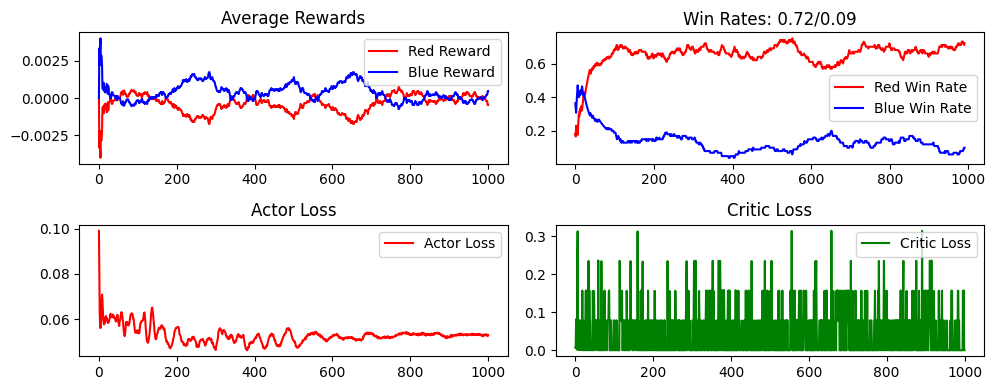

In [6]:
env = BattleEnv()
agent = MADDPG(env,
               actor_lr=1e-4, critic_lr=1e-3,
               noise_scale=0.4,
               noise_decay=0.99,
               BELIEVE=False,
               FULL=False)
train(agent, episodes=1000)

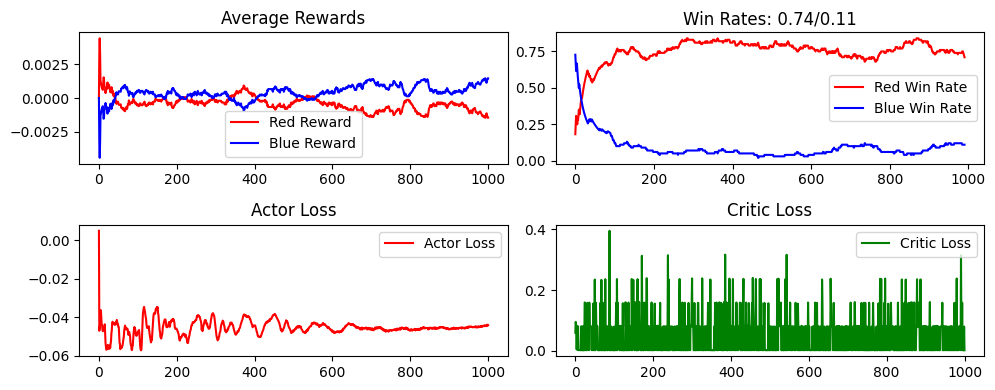

In [8]:
env = BattleEnv()
agent = MADDPG(env,
               actor_lr=1e-4, critic_lr=1e-3,
               noise_scale=0.4,
               noise_decay=0.99,
               BELIEVE=True,
               FULL=False)
train(agent, episodes=1000, print_interval=10, save_interval=50)

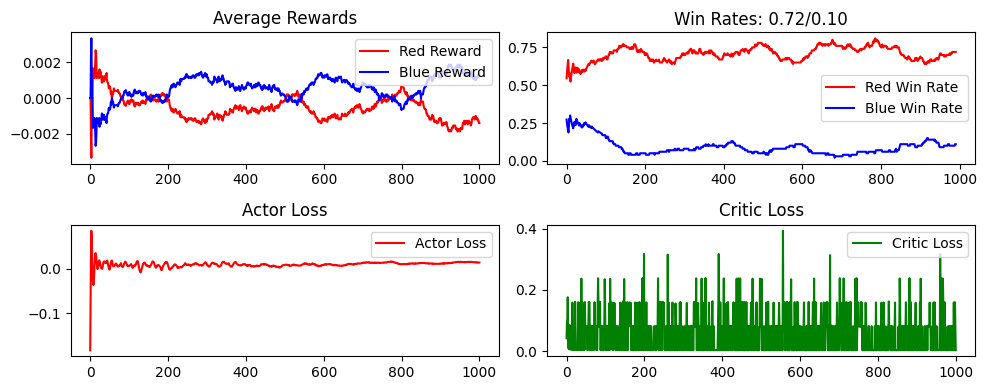

In [9]:
env = BattleEnv()
agent = MADDPG(env,
               actor_lr=1e-4, critic_lr=1e-3,
               noise_scale=0.4,
               noise_decay=0.99,
               BELIEVE=False,
               FULL=True)
train(agent, episodes=1000, print_interval=10, save_interval=50)